# Model Evaluation and Hyperparameter Tuning

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

The first two column of the dataset stores the unique ID numbers of the samples of the corresponding diagnosis ( M = malignant, B = benign ). This is a task to predict whether a tumor is benign or malignant.

In [2]:
df = pd.read_csv( 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', 
                  header = None )
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Extract the input and output features and label encode the output feature's class.

In [3]:
x = df.iloc[ :, 2: ].values
y = df.iloc[ :, 1 ].values
le = LabelEncoder()
y = le.fit_transform(y)

Split the full dataset into 80 training / 20 testing.

In [4]:
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size = 0.20, random_state = 1 )

## Pipeline

Using the `Pipeline` functionality to fit a model containing arbitrary number of transformation steps. If we wish to standardize the columns; compress the dataset from the initial 30 dimension into only 2 dimension and train a logistic regression on it. We can do this via `Pipeline`.

`Pipeline` takes a list of tuples as input. Where the first element of each tuple is a string identifier that we can later access and the second element in every tuple is a scikit-learn transformer or estimator.

In [5]:
# fit the pipeline and score on the test set
pipe1 = Pipeline([
    ( "sc", StandardScaler() ),
    ( "pca", PCA( n_components = 2 ) ),
    ( "lr", LogisticRegression( random_state = 1 ) )
])
pipe1.fit( x_train, y_train )
print( "Test Accuracy %.3f" % pipe1.score( x_test, y_test ) )

Test Accuracy 0.947


You can obtain the parameters of each step by calling `.get_params()`, which returns a dictionary of all the parameters for every transformers and estimators in the pipeline. Each parameters can be accessed via the transformers / estimators' string name that you gave plus `__` (two underscore).

In [6]:
# e.g. obtaining the cost for the logistic regression, which we named "lr" in the Pipeline
pipe1.get_params().get("lr__C")

1.0

## K-Fold & Holdout Cross Validation

Select the optimal values of the model's parameter and assess its performance.

One way is to split the data into training / validation / testing. Though this method is sensitive to how we partition the dataset.

So an alternative will be to use k-fold cross-valiation. A slight improvement over the standard k-fold cross-validation is the StratifiedKfold. This method can yield better bias and variance estimate, especially in cases of unequal class proportions as class proportions are preserved in each fold.

In [7]:
from sklearn.cross_validation import StratifiedKFold
kfold = StratifiedKFold( y = y_train, 
                         n_folds = 10,
                         random_state = 1 )

kfold holds the training and testing index for each fold ( stored in a tuple ).

The following section prints out the prediction accuracy for each fold and also shows the distribution of the class, using `np.bincount` ( counts the number of occurences for each int value ).

In [8]:
scores = []
for k, (train, test) in enumerate(kfold) :
    pipe1.fit( x_train[train], y_train[train] )
    score = pipe1.score( x_train[test], y_train[test] )
    scores.append(score)
    print( "Fold %s, Class Dist: %s, Acc: %.3f" % ( k + 1, np.bincount(y_train[train]), score ) )

Fold 1, Class Dist: [256 153], Acc: 0.891
Fold 2, Class Dist: [256 153], Acc: 0.978
Fold 3, Class Dist: [256 153], Acc: 0.978
Fold 4, Class Dist: [256 153], Acc: 0.913
Fold 5, Class Dist: [256 153], Acc: 0.935
Fold 6, Class Dist: [257 153], Acc: 0.978
Fold 7, Class Dist: [257 153], Acc: 0.933
Fold 8, Class Dist: [257 153], Acc: 0.956
Fold 9, Class Dist: [257 153], Acc: 0.978
Fold 10, Class Dist: [257 153], Acc: 0.956


Using sklearn's automated `cross_val_score` to achieve the same thing. The nice thing about using this function call is that we can set the `n_jobs` parameters to -1 to make use of all available CPUs on our machine to do the computation.

In [9]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score( pipe1, x_train, y_train, cv = 10, n_jobs = 2 )
print( scores )
print( 'CV accuracy: %.3f +/- %.3f' % ( np.mean(scores), np.std(scores) ) )

[ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
CV accuracy: 0.950 +/- 0.029


This returns an array of scores, where the length is equal to the number of fold.

## Learning Curve

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve

The `learning_curve` function is used to diagnose bias and variance problems.

`np.linspace` is similar to `arange` except it uses the number of samples instead of step size as the third parameter.

In [11]:
pipe_lr = Pipeline([
    ( 'scl', StandardScaler() ),
    ( 'lr', LogisticRegression( penalty = 'l2', random_state = 0 ) )
])

train_sizes, train_scores, test_scores = learning_curve(
    estimator = pipe_lr, 
    X = x_train, 
    y = y_train, 
    train_sizes = np.linspace( 0.1, 1.0, 10 ), # controls the proportion of the training size
    cv = 10,
    n_jobs = 1
)

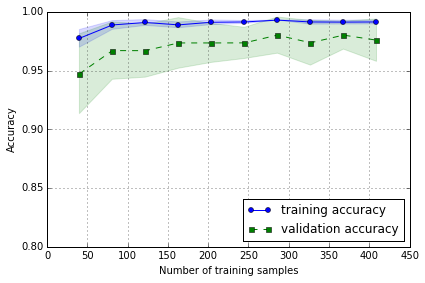

In [12]:
def plot_learning_curves( train_sizes, train_scores, test_scores ) :
    
    # calculate the mean and the standard deviation of each score (using different training sizes)
    train_mean = np.mean( train_scores, axis = 1 )
    train_std = np.std( train_scores, axis = 1 )
    test_mean = np.mean( test_scores, axis = 1 )
    test_std = np.std( test_scores, axis = 1 )

    plt.plot(train_sizes, train_mean, 
             color='blue', marker='o', 
             markersize=5, label='training accuracy')

    plt.fill_between(train_sizes, 
                     train_mean + train_std,
                     train_mean - train_std, 
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, 
             color='green', linestyle='--', 
             marker='s', markersize=5, 
             label='validation accuracy')

    plt.fill_between(train_sizes, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color='green')
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.8, 1.0])
    plt.tight_layout()
    plt.show()
    
plot_learning_curves( train_sizes, train_scores, test_scores )

The preceding learning curve plot shows that our model performs quite well on the test dataset.

# Validation Curve

The `validation_curve` plots the influence of a single hyperparameter on the training score and the validation score.

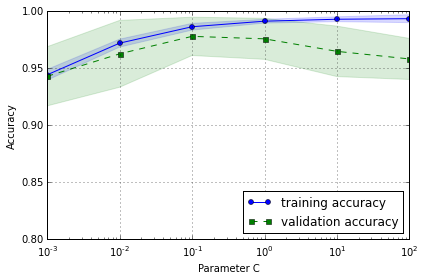

In [13]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator = pipe_lr, 
    X = x_train, 
    y = y_train, 
    param_name = 'lr__C', # specify the parameter to evaluate
    param_range = param_range, # specify the range of the parameter
    cv = 10
)

train_mean = np.mean( train_scores, axis = 1 )
train_std = np.std( train_scores, axis = 1 )
test_mean = np.mean( test_scores, axis = 1 )
test_std = np.std( test_scores, axis = 1 )

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

The plot shows that the accuracy for varying values of C are subtle.

## Grid Search

Finding the optimal combinations of hyperparmeter values.

In [14]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

Specify the `param_grid` using a list of dictionaries. Then obtain the `best_score_` and `best_params_`.

In [15]:
pipe_svc = Pipeline([
    ( 'scl', StandardScaler() ),
    ( 'clf', SVC( random_state = 1 ) )
])

param_range = [ 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0 ]

param_grid = [
    { 'clf__C' : param_range, 
      'clf__kernel': ['linear'] },
    { 'clf__C': param_range, 
      'clf__gamma': param_range, 
      'clf__kernel': ['rbf'] }
]

gs = GridSearchCV( estimator = pipe_svc, 
                   param_grid = param_grid, 
                   scoring = 'accuracy', 
                   cv = 10,
                   n_jobs = -1 )
gs = gs.fit( x_train, y_train )
print(gs.best_score_)
print(gs.best_params_)

0.978021978022
{'clf__C': 0.1, 'clf__kernel': 'linear'}


Then use the `best_estimator` to estimate the performance of the best selected model.

In [16]:
clf = gs.best_estimator_
clf.fit( x_train, y_train )
print( 'Test accuracy: %.3f' % clf.score( x_test, y_test ) )

Test accuracy: 0.965


End Note : Although `GridSearchCV` is a extremely powerful approach for finding the optimal set of parameters, sometimes it is better to use `RandomizedSearchCV` to lower the run time of hyperparameter tuning.

## Nested Cross Validation

This is where you have a outer k-fold cross-validation to split the data into training and testing folds. Then another inner k-fold is used to tune the parameters, and the model is evaluated using the testing fold in the outer k-fold.

In [17]:
gs = GridSearchCV(
    estimator = pipe_svc, 
    param_grid = param_grid, 
    scoring = 'accuracy', 
    cv = 5
)
scores = cross_val_score( gs, x_train, y_train, scoring = 'accuracy', cv = 5 )
print( 'CV accuracy: %.3f +/- %.3f' % ( np.mean(scores), np.std(scores) ) )

CV accuracy: 0.978 +/- 0.012


## Different Performance Metrics

Obtaining the confusion matrix and visualize it.

In [18]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit( x_train, y_train )
y_pred = pipe_svc.predict( x_test )
conf_mat = confusion_matrix( y_true = y_test, y_pred = y_pred )
print( conf_mat )

[[71  1]
 [ 2 40]]


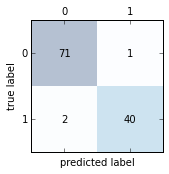

In [19]:
# visualizing the confusion matrix
fig, ax = plt.subplots( figsize = ( 2.5, 2.5 ) )
ax.matshow( conf_mat, cmap = plt.cm.Blues, alpha = 0.3 )

for i in range( conf_mat.shape[0] ) :
    for j in range( conf_mat.shape[1] ) :
        # be careful with the ordering of x, y
        ax.text( x = j, y = i, s = conf_mat[ i, j ], va = "center", ha = "center" )
        
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()
plt.show()

- `False Positive Rate` We want to decrease that number of tumors that were incorrectly classified as malignant ( false positive ).
- `Precision`. $\frac{TP}{ TP + FP}$
- `Recall`. Equivalent to a true positive rate, which is the fraction of positive samples that were correctly identified out of the total pool of positives.
- `F1 Score`. $2\frac{precision \times recall}{precision + recall}$

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer

print( 'Precision: %.3f' % precision_score( y_true = y_test, y_pred = y_pred ) )
print( 'Recall: %.3f' % recall_score( y_true = y_test, y_pred = y_pred ) )
print( 'F1: %.3f' % f1_score( y_true = y_test, y_pred = y_pred ) )

Precision: 0.976
Recall: 0.952
F1: 0.964


Change the scoring metric of the model fit using `make_scorer`.

In [21]:
# pos_label is a parameter that's pass to the f1_score
scorer = make_scorer( f1_score, pos_label = 0 ) 
c_gamma_range = [ 0.01, 0.1, 1.0, 10.0 ]

param_grid = [
    { 'clf__C': c_gamma_range, 
      'clf__kernel': ['linear'] },
    { 'clf__C': c_gamma_range, 
      'clf__gamma': c_gamma_range, 
      'clf__kernel': ['rbf'] }
]

gs = GridSearchCV(
    estimator = pipe_svc, 
    param_grid = param_grid, 
    scoring = scorer, 
    cv = 10,
    n_jobs = -1
)
gs = gs.fit( x_train, y_train )
print(gs.best_score_)
print(gs.best_params_)

0.982798668208
{'clf__C': 0.1, 'clf__kernel': 'linear'}


## ROC Curve

Selecting the models for classification based on their performance with respect to the false positive and true positive rate.

In [22]:
from sklearn.metrics import roc_curve, auc

x_train2 = x_train[ :, [ 4, 14 ] ]
cv = StratifiedKFold( y = y_train, n_folds = 3, random_state = 1 )

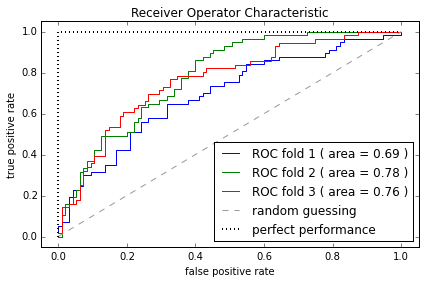

In [23]:
# plot the roc curve for every fold
for i, ( train, test ) in enumerate(cv) :
    probas = pipe_lr.fit( x_train2[train], y_train[train] ).predict_proba( x_train2[test] )
    # calling the roc_curve, extract the probability of the class label 1 from @probas
    fpr, tpr, thresholds = roc_curve( y_train[test], probas[ :, 1 ], pos_label = 1 )   
    roc_auc = auc( fpr, tpr )
    plt.plot( fpr, tpr, lw = 1, label = "ROC fold %d ( area = %0.2f )" % ( ( i + 1 ), roc_auc ) )

plt.plot( [0, 1], 
          [0, 1], 
          linestyle = '--', 
          color = (0.6, 0.6, 0.6), 
          label = 'random guessing' )
plt.plot( [0, 0, 1], 
          [0, 1, 1], 
          lw = 2, 
          linestyle = ':', 
          color = 'black', 
          label = 'perfect performance' )

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

The plot above shows that there's a certain degree of variance between the different folds.

Now if we only wish to obtain the auc score. We can use the `roc_auc_score` module.

In [24]:
from sklearn.metrics import roc_auc_score

pipe_svc = pipe_svc.fit(x_train2, y_train)
y_pred2 = pipe_svc.predict(x_test[:, [4, 14]])
print( 'ROC AUC: %.3f' % roc_auc_score( y_true = y_test, y_score = y_pred2 ) )

ROC AUC: 0.671
